# Additive Modelling
In this notebook we demonstrate how to fit an additive Gaussian process model in GPJax, first demonstrating the initial "Additive Gaussian Process" of [Devenaud et al. (2011)](https://proceedings.neurips.cc/paper_files/paper/2011/hash/4c5bde74a8f110656874902f07378009-Abstract.html) and then the recent "Orthogonal Additive Gaussian Process" of [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf).


In [1]:
import jax
# Enable Float64 for more stable matrix inversions.
jax.config.update("jax_enable_x64", True)

from dataclasses import dataclass
import warnings
from typing import List, Union

import cola

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarFloat,
)
import optax as ox
from gpjax.distributions import GaussianDistribution
from gpjax.kernels import AdditiveKernel

import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]


ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/henry/anaconda3/envs/gpjax/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/henry/anaconda3/envs/gpjax/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


In [189]:
# prepare some plotting utilities
x1_plot, x2_plot = jnp.meshgrid(jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50))
xplot2d = jnp.stack([x1_plot.reshape(-1), x2_plot.reshape(-1)]).T # [2500, 2]
xplot1d = jnp.stack([jnp.linspace(-1.5,1.5,50), jnp.zeros((50))]).T # [50, 2]
def contour_plot(Z, ax):
    Z = Z.reshape(50, 50)
    cp = ax.contourf(x1_plot, x2_plot, Z)
    ax.scatter(X[:,0], X[:,1], c="red", marker="x", label="data")
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    return cp

In [215]:
# plotting util
def plot_posterior_with_components_1(opt_posterior, delta =0.01, sobol=False):

    fig, ax = plt.subplots(nrows=1, ncols=4)
    for i, components in enumerate([[],[0],[1],[0,1]]): # make 1d plots of 1d interactions
        
        if len(components)==0:
            pass
        elif len(components)==1:
            if components[0]==0:
                xplot1d = jnp.stack([jnp.linspace(-1.5,1.5,50), jnp.zeros((50))]).T # [50, 2]
            else:
                xplot1d = jnp.stack([jnp.zeros((50)), jnp.linspace(-1.5,1.5,50)]).T # [50, 2]
            posterior = opt_posterior.predict_additive_component(xplot1d, D, delta=delta, component_list=components)

            mean, std = posterior.mean(), posterior.stddev()
            ax[i].plot(xplot1d[:,components[0]], mean, color="blue", label="additive")
            ax[i].fill_between(xplot1d[:,components[0]], mean - 2 * std,mean + 2 * std, alpha=0.2, color="blue")
            truth = xplot1d[:,components[0]]**2 if components[0]==0 else -2*xplot1d[:,components[0]]
            ax[i].plot(xplot1d[:,components[0]], truth, color="black", label="truth")
        elif len(components)==2:
            contour_plot(opt_posterior.predict_additive_component(xplot2d, D, delta=delta, component_list = components).mean(), ax[i])

        ax[i].legend()

    
# plotting util
def plot_posterior_with_components_2(opt_posterior, delta =0.01, sobol=False):

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for i, components in enumerate([[],[0],[1],[0,1]]): # make 1d plots of 1d interactions
        cp = contour_plot(opt_posterior.predict_additive_component(xplot2d, D, delta=delta, component_list = components).mean(), ax[i])
        fig.colorbar(cp, ax=ax[i])
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"




## Make a toy dataset
We first simulate some data, following the 2d toy problem used as motivation by [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf)

In particular, we consider learning a 2d function that can be decomposed additively.

$f(x_1,x_2) = x_1^2 - 2x_2 + \cos(3x_1)\sin(5x_2)$

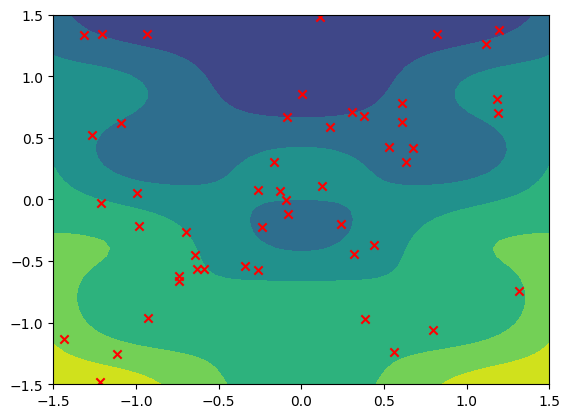

In [174]:
import math
# ground truth function
def f(x): 
    return x[:,0:1]**2 - 2*x[:,1:2] + jnp.cos(3*x[:,0:1])*jnp.sin(5*x[:,1:2])

# simulate a noisy dataset of 50 noisy observations
n, noise = 50, 0.01


# X = jr.normal(jr.PRNGKey(12345), shape=(n,2)) 
# theta = jr.uniform(jr.PRNGKey(12345), shape=(n,))*2.0*math.pi
# r = jr.uniform(jr.PRNGKey(134), shape=(n,)) + 0.8
# X = jnp.stack([r*jnp.cos(theta), r*jnp.sin(theta)]).T
X = jr.uniform(jr.PRNGKey(12345), shape=(n,2), minval=-1.5, maxval=1.5)
X = jnp.clip(X,-1.5,1.5)
y = f(X) + jr.normal(jr.PRNGKey(12345), shape= (n, 1)) * noise
D = gpx.Dataset(X=X, y=y)

# plot the ground truth function
fig, ax = plt.subplots()
contour_plot(f(xplot2d), ax)

In [204]:
from gpjax.base import static_field
import math
import numpy as np


@dataclass()
class AdditiveConjugatePosterior(gpx.gps.ConjugatePosterior):
    r"""
    Build an additive posterior from an additive kernel and a Gaussian likelihood. We have included an
    additional method to allow predictions for specific additive components, as specified by a
    component_list, e.g. [0, 1] corresponds to the second order interaction between zeroth and first inputs.
    """
    n_quad_points: int = static_field(100)
    def __post__init__(self):
        assert isinstance(self.prior.kernel, gpx.kernels.RBF), "Only works for RBF atm"

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: gpx.Dataset,
        delta = 1.0,
        component_list: List[List[int]]=[],
    ) -> GaussianDistribution:
        r"""Get the posterior predictive distribution for a specific additive component."""
        specific_kernel = New(lengthscale=self.prior.kernel.lengthscale, variance=self.prior.kernel.variance, delta=delta, component_list=component_list,n_quad_points=self.n_quad_points)
        return self.predict(test_inputs, train_data, kernel_with_test = specific_kernel)



@dataclass()
class New(gpx.kernels.AbstractKernel):
    r"""todo only for unit gaussian input measure and zero mean."""
    # name: str = "OrthogonalRBF"
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = gpx.param_field(jnp.array(1.0))
    variance: Union[ScalarFloat, Float[Array, " D"]] = gpx.param_field(jnp.array(1.0))
    delta: ScalarFloat = static_field(1e-3)
    locs: Float[Array, " N"] = static_field(None)
    weights: ScalarFloat = static_field(None)
    n_quad_points: int = static_field(100)
    component_list: List[int] = static_field([])

    def __post_init__(self):
        locs, weights = np.polynomial.legendre.leggauss(self.n_quad_points)
        self.locs = jnp.array(locs) 
        self.weights = jnp.array(weights)[:,None] * jax.scipy.stats.norm.pdf(self.locs[:,None],loc=jnp.zeros_like(self.lengthscale)[None,:], scale=1.0 / (2.0  * self.lengthscale[None,:]*math.pi * self.delta)) 


    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute an orthogonal RBF kernel between a pair of arrays."""
        assert x.shape[0]==2
        # x = self.slice_input(x) # [d]
        # y = self.slice_input(y) # [d]
        ks = jnp.exp(-0.5 * ((x - y) / self.lengthscale) ** 2) # [d]
        inactive_dims = jnp.array([i for i in range(x.shape[0]) if i not in self.component_list])
        delta_values = self._calc_delta_values(x, y, self.lengthscale)
        if len(self.component_list)==0:
            k = jnp.prod(delta_values)
        elif len(self.component_list)==1:
            k = (ks[self.component_list[0]] - delta_values[self.component_list[0]])*jnp.prod(delta_values[inactive_dims])
        else: 
            k = jnp.prod(ks) - delta_values[0] * ks[1] - delta_values[1] * ks[0] + delta_values[0] * delta_values[1]
        return self.variance * k


    def _calc_delta_values(self, x, y, lengthscale):
        return jnp.sum(jnp.cos(2.0*math.pi*self.delta*self.locs[:,None]*((x-y))[None,:])*self.weights,0) * jnp.sqrt(2.0*math.pi) * lengthscale
        #return jnp.mean(jnp.cos(self.samples*(x-y)/lengthscale)) * self.Z
        #return 1.0 - 0.5*(((x-y)/lengthscale)**2)*(1.0 - 2*self.delta*jax.scipy.stats.norm.pdf(self.delta)/self.Z)



  0%|          | 0/100 [00:00<?, ?it/s]

AdditiveConjugatePosterior(prior=Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([0.67342553, 0.53086275], dtype=float64), variance=Array(5.15174983, dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=50, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01, dtype=float32)), jitter=1e-06, n_quad_points=10)


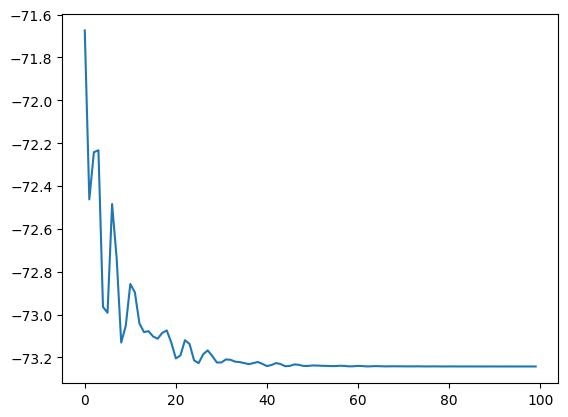

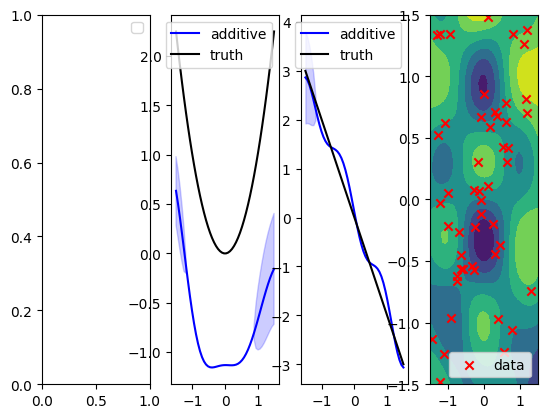

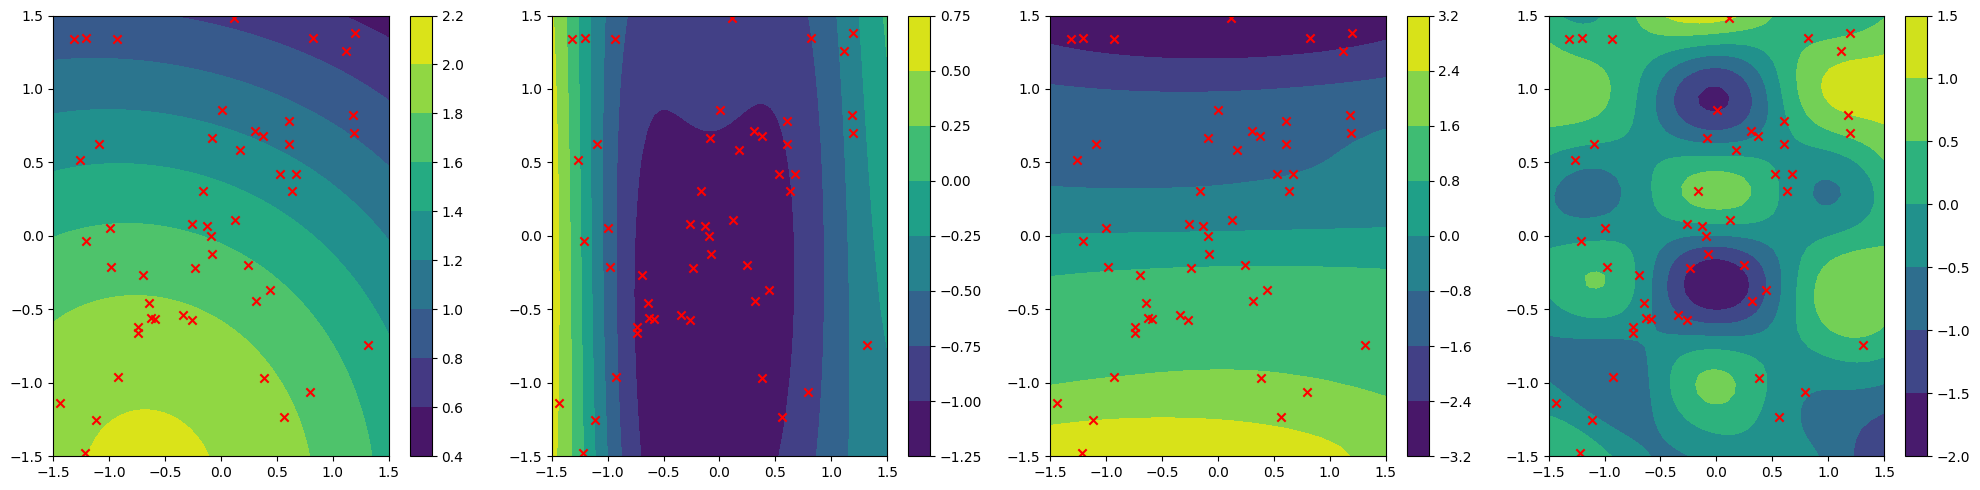

In [217]:
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(kernel=gpx.kernels.RBF(lengthscale=jnp.array([0.7,0.5], dtype=jnp.float64), variance=jnp.array(4.0, dtype=jnp.float64)), mean_function = gpx.mean_functions.Zero())
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise).replace_trainable(obs_stddev= False)
obj = gpx.objectives.ConjugateLOOCV(negative=True)
posterior = AdditiveConjugatePosterior(prior =prior, likelihood=likelihood, n_quad_points=10)


opt_posterior = posterior
opt_posterior, history = gpx.fit(model=posterior, objective=obj, train_data=D, verbose=True, optim=ox.adam(0.1), key=jr.PRNGKey(1234), num_iters=100)
plt.plot(history)
print(opt_posterior)

# plot learned additive components
plot_posterior_with_components_1(opt_posterior, delta=0.1)
plot_posterior_with_components_2(opt_posterior, delta=0.1)




We can also look at the individual additive components learned by the second order model

TypeError: list indices must be integers or slices, not list

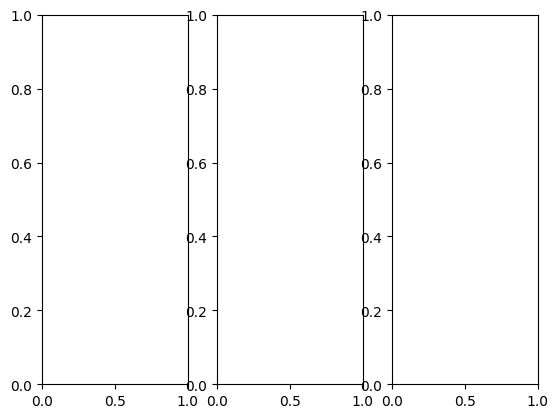

In [10]:
# plotting util
def plot_posterior_with_components(opt_posterior, sobol=False):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    for i in [0,1]: # make 1d plots of 1d interactions
        posterior = opt_posterior.predict_additive_component(xplot1d, D, [i])
        mean, std = posterior.mean(), posterior.stddev()
        ax[i].plot(xplot1d[:,i], mean, color="blue", label="additive")
        ax[i].fill_between(xplot1d[:,i], mean - 2 * std,mean + 2 * std, alpha=0.2, color="blue")
        ax[i].set_title(f"$f_{i}(x_{i})$" if not sobol else f"$f_{i}(x_{i})$ has sobol ${opt_posterior.get_sobol_index(D, [i]):.2f}$")
        truth = xplot1d[:,i]**2 if i==0 else -2*xplot1d[:,i]
        ax[i].plot(xplot1d[:,i], truth, color="black", label="truth")
        ax[i].legend()

    # plot 2d interaction
    ax[2].set_title(f"$f_3(x_1,x_2)$" if not sobol else f"$f_3(x_1,x_2)$ has sobol ${opt_posterior.get_sobol_index(D, [0, 1]):.2f}$")
    contour_plot(opt_posterior.predict_additive_component(xplot2d, D, [0, 1]).mean(), ax[2])

# plot learned additive components
plot_posterior_with_components(opt_posterior)

Although the mean predictions are reasonably close to the true values of the additive components $x_1^2$ and $-2x_2$ there is a large ammount of uncertainty. [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf) argue that the high uncertainty is a consequence of the lack of exisiting of an unique additive decomposition. For example
$$
f(x_1,x_2) = (f(x_1) + \Delta_1(x_1)) + (f(x_2) + \Delta_2(x_2)) + (f_{12}(x_1, x_2) - \Delta_1(x_1) - \Delta_2(x_2))
$$
is a valid additive decomposition for any functions $\Delta_1(x_1)$ and $\Delta_2(x_2)$. 

## Roll on the "Orthogonal Additive Kernel"

To mitigate the problem of identifiability, [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf) apply an additional constraint to each base kernel so that the integral of each function $\{f_i\}_{i=1}^D$ (with respect to some chosen measure) is zero, thus resulting in a unique decomposition. When $f$ has a non-zero mean, a constant offset is included.

More precisely, we "orthogonalise"  base kernel $i$ by conditioning on the event $\int f_i(x_i)p(x_i)dx_i = 0$. Fortunateky, conditioning a GP on a linear operator also results in a GP and so (for certain base measures $p(x_i)$) our model remains tractible. In our implentation below, we assume a unit Gaussian input measure, so you may achieve better results if you transform your inputs to match.

In [ ]:
@dataclass()
class OrthogonalRBF(gpx.kernels.AbstractKernel):
    r"""todo only for unit gaussian input measure and zero mean."""
    name: str = "OrthogonalRBF"
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = gpx.param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )

    def __post_init__(self):
        warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute an orthogonal RBF kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.exp(-0.5 * ((x - y) / self.lengthscale) ** 2) # [d]
        ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
        return jnp.prod(ks)
    
    def _cov_x_s(self,x):
        l2 = self.lengthscale ** 2
        return jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (x ** 2) / (l2 + 1.0)) # [d]
        
    def _var_s(self):
        return  jnp.sqrt(self.lengthscale ** 2 / (self.lengthscale ** 2 + 2.0)) # [d]


Now, lets use this new kernel to recreate the plots from above.

In [ ]:
base_kernels = [OrthogonalRBF(active_dims=[0], lengthscale=jnp.array([1.0])), OrthogonalRBF(active_dims=[1], lengthscale=jnp.array([1.0]))]

fig, ax = plt.subplots(nrows=1, ncols=3)
for i in [0,1,2]:
    
    kernel = AdditiveKernel(
        kernels=base_kernels,
        interaction_variances=jnp.array([1.0]*(i+1)) * jnp.var(D.y), 
        max_interaction_depth=i, 
        )

    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    posterior = AdditiveConjugatePosterior(prior =prior, likelihood=likelihood)
    opt_posterior, history = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=False)
    contour_plot(opt_posterior.predict(xplot2d, D).mean(), ax[i])
    ax[i].set_title(f"max interaction={i}")

# plot additive components
plot_posterior_with_components(opt_posterior, sobol=True)

By "orthogonalising" our kernel and so providing an identifiable decomposition, we have greatly reduced the uncertainty of our additve model and have much tighter estimates of the univariate additive components. Note that the constant gap between the truth and our estimated $f_0$ is expected and is accounted for by the not-plotted constant interaction.